In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import matplotlib.pyplot as plt
import xgboost as xgb

In [2]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

# target variable
y = df_train['SalePrice']
test_ids = df_test['Id']

# mark the datasets
df_train['source'] = 'train'
df_test['source'] = 'test'
df = pd.concat([df_train.drop('SalePrice', axis=1), df_test], ignore_index=True)
df.loc[df['source'] == 'train', 'SalePrice'] = y.values

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64


<ipython-input-4-f6257828a426>:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(y, color='g', bins=100, hist_kws={'alpha': 0.4});


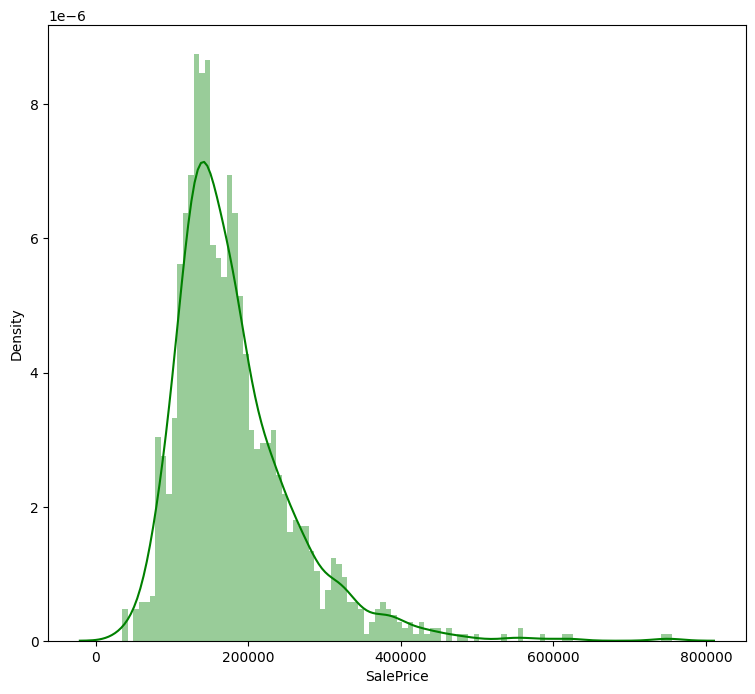

In [4]:
print(y.describe())
plt.figure(figsize=(9, 8))
sns.distplot(y, color='g', bins=100, hist_kws={'alpha': 0.4});
# let's see the distribution

In [5]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': 100 * missing / len(df)})
missing_df

,Missing Count,Percentage
PoolQC,2909,99.657417
MiscFeature,2814,96.402878
Alley,2721,93.216855
Fence,2348,80.438506
MasVnrType,1766,60.500171
SalePrice,1459,49.982871
FireplaceQu,1420,48.646797
LotFrontage,486,16.649538
GarageQual,159,5.447071
GarageYrBlt,159,5.447071


In [6]:
df.drop(['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu'] , axis=1, inplace=True)

In [7]:
df['LotFrontage_missing'] = df['LotFrontage'].isnull().astype(int)
num_cols = df.select_dtypes(include=['int64', 'float64']).columns

correlations = df[num_cols].corr()['LotFrontage_missing'].sort_values(ascending=False)
print(correlations.head(10))
# Is LotFrontage correlating with other numerical features? Not really

LotFrontage_missing    1.000000
LotArea                0.125378
Fireplaces             0.123560
WoodDeckSF             0.087103
BsmtFinSF1             0.077782
HalfBath               0.068023
YearBuilt              0.060303
BsmtFullBath           0.056240
GarageCars             0.056074
GrLivArea              0.047716
Name: LotFrontage_missing, dtype: float64


Text(0.5, 1.0, 'LotFrontage Histogram')

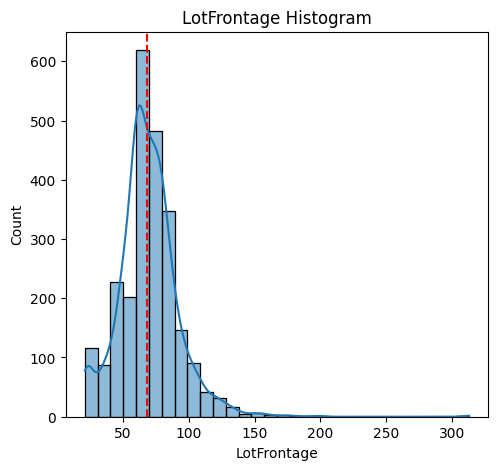

In [8]:
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
sns.histplot(df['LotFrontage'].dropna(), bins=30, kde=True)
plt.axvline(df['LotFrontage'].median(), color='red', linestyle='--')
plt.title("LotFrontage Histogram")
# It is left skewed, maybe we can fill missing values with median.

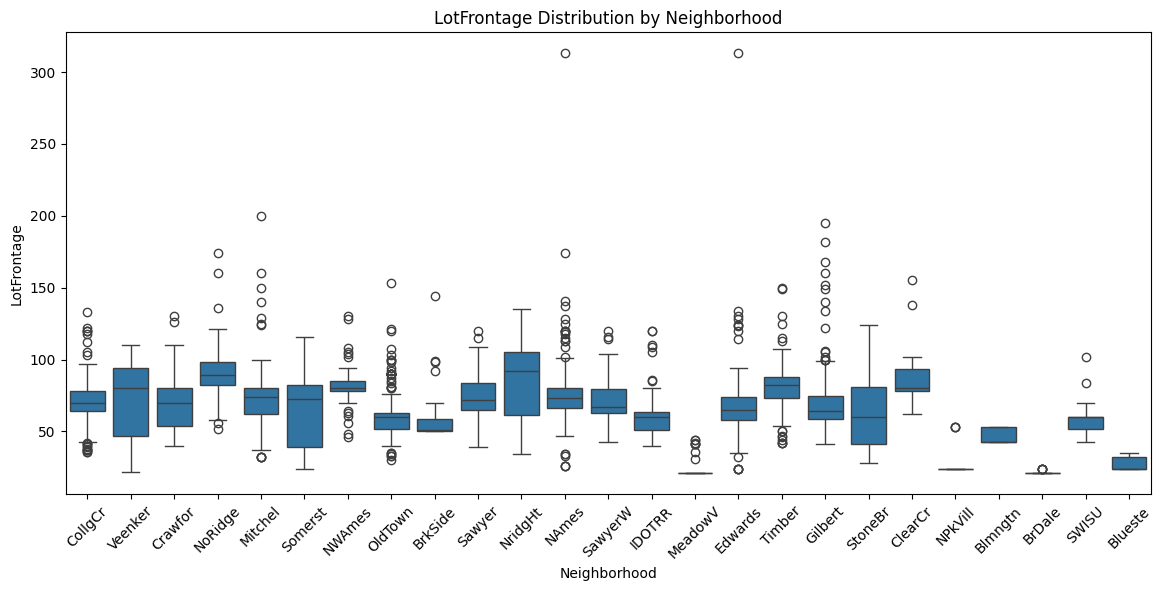

In [9]:
# LotFrontage by Neighborhood
plt.figure(figsize=(14,6))
sns.boxplot(x='Neighborhood', y='LotFrontage', data=df)
plt.xticks(rotation=45)
plt.title("LotFrontage Distribution by Neighborhood")
plt.xlabel("Neighborhood")
plt.ylabel("LotFrontage")
plt.show()
# does median show a difference by neighbourhood? Yes, makes sense!


In [10]:
# fill the missing LotFrontage with median LotFrontage for each neighborhood
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(
    lambda x: x.fillna(x.median()))


In [11]:
missing = df.isnull().sum()
missing = missing[missing > 0].sort_values(ascending=False)
missing_df = pd.DataFrame({'Missing Count': missing, 'Percentage': 100 * missing / len(df)})
missing_df
# Sale price seems to have null because, test data do not have sale price.

,Missing Count,Percentage
SalePrice,1459,49.982871
GarageQual,159,5.447071
GarageFinish,159,5.447071
GarageYrBlt,159,5.447071
GarageCond,159,5.447071
GarageType,157,5.378554
BsmtCond,82,2.809181
BsmtExposure,82,2.809181
BsmtQual,81,2.774923
BsmtFinType2,80,2.740665


In [11]:
# Create helper columns for each missing feature safely
for col in missing.index:
    new_col = f'{col}_missing'
    if new_col not in df.columns:
        df[new_col] = df[col].isnull().astype(int)

for col in missing_df.index:
    print(f"\n--- Correlation for: {col}_missing ---")
    corrs = df.corr(numeric_only=True)[f'{col}_missing'].sort_values(ascending=False).head(10)
    print(corrs)



--- Correlation for: SalePrice_missing ---
SalePrice_missing       1.000000
MSZoning_missing        0.037056
MasVnrArea_missing      0.027153
BsmtFullBath_missing    0.026194
BsmtHalfBath_missing    0.026194
Functional_missing      0.026194
Utilities_missing       0.026194
GarageCars_missing      0.018519
GarageArea_missing      0.018519
Exterior2nd_missing     0.018519
Name: SalePrice_missing, dtype: float64

--- Correlation for: GarageQual_missing ---
GarageCond_missing      1.000000
GarageYrBlt_missing     1.000000
GarageQual_missing      1.000000
GarageFinish_missing    1.000000
GarageType_missing      0.993331
KitchenAbvGr            0.182468
MSSubClass              0.109908
BsmtFinType1_missing    0.090206
BsmtFinType2_missing    0.089153
BsmtQual_missing        0.088116
Name: GarageQual_missing, dtype: float64

--- Correlation for: GarageFinish_missing ---
GarageCond_missing      1.000000
GarageYrBlt_missing     1.000000
GarageQual_missing      1.000000
GarageFinish_missing    

<ipython-input-12-7877ee39af53>:7: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128269 (\N{LEFT-POINTING MAGNIFYING GLASS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


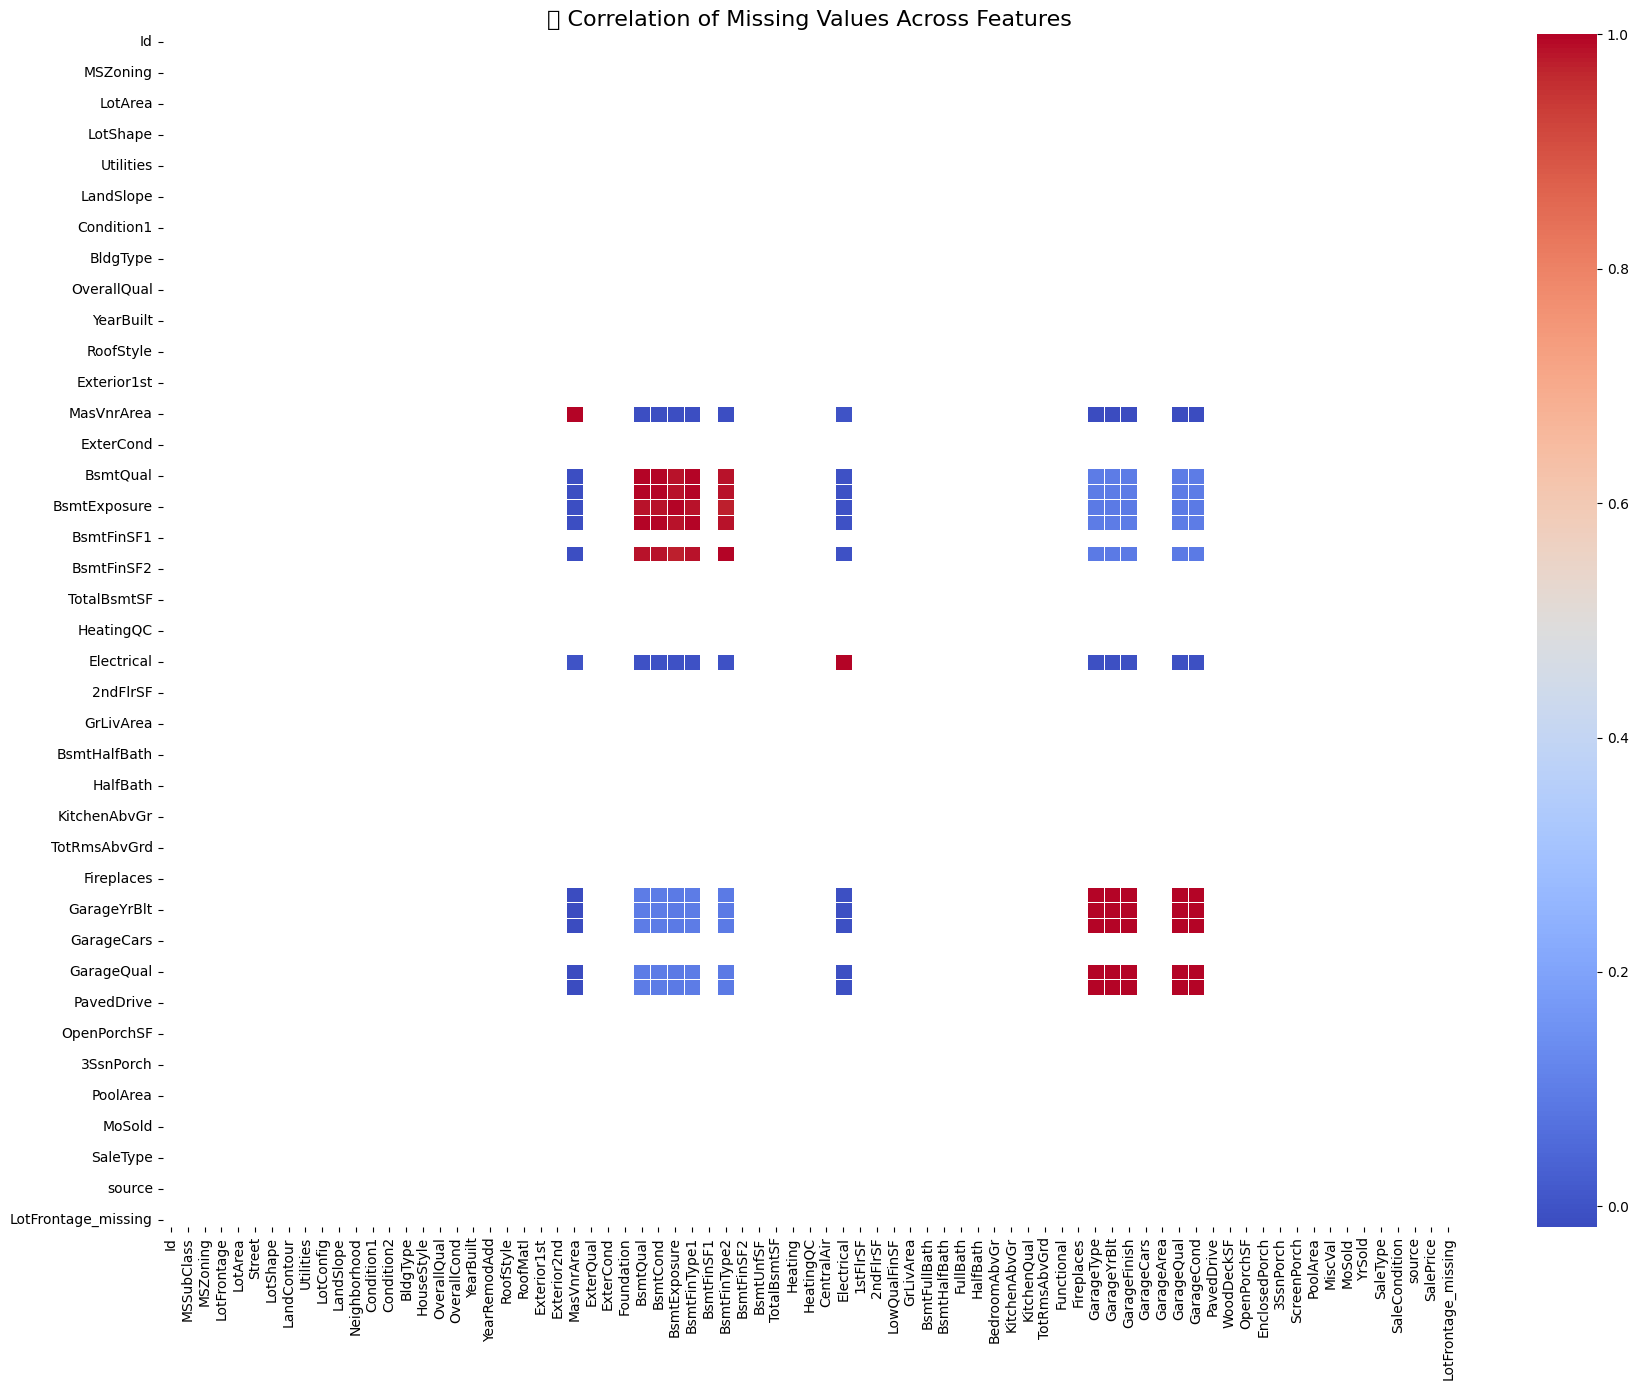

In [12]:
# let's check visually
missing_left = df[df['source'] == 'train'].isnull().astype(int)
missing_corr = missing_left.corr()
plt.figure(figsize=(18, 14))
sns.heatmap(missing_corr, cmap='coolwarm', annot=False, linewidths=0.5)
plt.title('🔍 Correlation of Missing Values Across Features', fontsize=16)
plt.tight_layout()
plt.show()

In [13]:
garage_cols = ['GarageArea', 'GarageCars', 'GarageYrBlt',
               'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']

# current train data
train = df[df['source'] == 'train']

# encoding categorical values for correlation check
garage_encoded = pd.get_dummies(train[garage_cols], drop_first=True)
garage_encoded['SalePrice'] = train['SalePrice']

# Compute correlations
corrs = garage_encoded.corr()['SalePrice'].sort_values(ascending=False)
print(corrs)


SalePrice             1.000000
GarageCars            0.640409
GarageArea            0.623431
GarageYrBlt           0.486362
GarageType_Attchd     0.335961
GarageCond_TA         0.275872
GarageQual_TA         0.245346
GarageType_BuiltIn    0.235449
GarageFinish_RFn      0.169792
GarageQual_Gd         0.043291
GarageCond_Gd        -0.000983
GarageType_Basment   -0.029425
GarageQual_Po        -0.046142
GarageCond_Po        -0.063296
GarageType_CarPort   -0.070371
GarageCond_Fa        -0.130774
GarageQual_Fa        -0.133142
GarageType_Detchd    -0.354141
GarageFinish_Unf     -0.410608
Name: SalePrice, dtype: float64


In [14]:
corr = train[['GarageCars', 'GarageArea']].corr()
print(corr)
# Maybe I can only process with the GarageCars.

            GarageCars  GarageArea
GarageCars    1.000000    0.882475
GarageArea    0.882475    1.000000


In [13]:
# === 🧱 Masonry Veneer ===
# If masonry veneer is missing, it likely means no veneer → fill accordingly
df['MasVnrArea'] = df['MasVnrArea'].fillna(0)

# === 🏠 Basement Features ===
# Missing values likely indicate no basement exists
bsmt_cols = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
for col in bsmt_cols:
    df[col] = df[col].fillna('None')

# Basement-related numeric features — no basement → fill with 0
bsmt_num_cols = ['BsmtFullBath', 'BsmtHalfBath', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF']
for col in bsmt_num_cols:
    df[col] = df[col].fillna(0)

# === 🚗 Garage Categorical Features ===
# If missing, assume no garage
garage_cat_cols = ['GarageType', 'GarageFinish', 'GarageQual', 'GarageCond']
for col in garage_cat_cols:
    df[col] = df[col].fillna('None')

# Garage numeric features — no garage → fill with 0
garage_num_cols = ['GarageCars', 'GarageArea']
for col in garage_num_cols:
    df[col] = df[col].fillna(0)

# === 🚧 GarageYrBlt ===
# WARNING: Filling with YearBuilt implies the garage exists!
# This is only safe if GarageType is not 'None'
df.loc[df['GarageType'] == 'None', 'GarageYrBlt'] = 0  # no garage
df['GarageYrBlt'] = df['GarageYrBlt'].fillna(df['YearBuilt'])  # garage exists but year is missing

# === ⚡ Electrical System ===
# Only one missing value → fill with most frequent category
df['Electrical'] = df['Electrical'].fillna(df['Electrical'].mode()[0])

# === 📐 LotFrontage ===
# Fill using the median LotFrontage within each Neighborhood
df['LotFrontage'] = df.groupby('Neighborhood')['LotFrontage'].transform(lambda x: x.fillna(x.median()))

# === 🧩 Other categorical features with rare missingness — fill with mode
cat_fill_mode = ['MSZoning', 'Utilities', 'Functional', 'Exterior1st', 'Exterior2nd',
                 'KitchenQual', 'SaleType']
for col in cat_fill_mode:
    df[col] = df[col].fillna(df[col].mode()[0])


In [14]:
missingLeft=df.isnull().sum()
missingLeft = missingLeft[missingLeft > 0].sort_values(ascending=False)
missingLeft

,0
SalePrice,1459


In [15]:
# 🧹 Drop all helper columns that end with '_missing'
df = df.drop(columns=[col for col in df.columns if col.endswith('_missing')])

In [35]:
df_train_final = df[df['source'] == 'train'].drop(['source'], axis=1).copy()
df_test_final = df[df['source'] == 'test'].drop(['source', 'SalePrice'], axis=1).copy()

In [36]:
X = df_train_final.drop('SalePrice', axis=1)
y = df_train_final['SalePrice']

In [21]:
# 🔄 Log transform target
y_log = np.log1p(y)

# 🔀 Train/test split
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 🧼 Preprocessing
num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# 🚀 model pipeline
model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        verbosity=0
    ))
])

# 🏋️‍♀️ Fit model
model.fit(X_train, y_train_log)

# 🔮 Predict
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_true = np.expm1(y_val_log)

# 📉 Evaluate
mae = mean_absolute_error(y_val_true, y_pred)
print(f"🚀 XGBoost MAE (log-transformed): {mae:.2f}")

🚀 XGBoost MAE (log-transformed): 15209.88


Text(0.5, 0, 'F Score')

/usr/local/lib/python3.11/dist-packages/IPython/core/events.py:89: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  func(*args, **kwargs)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128640 (\N{ROCKET}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


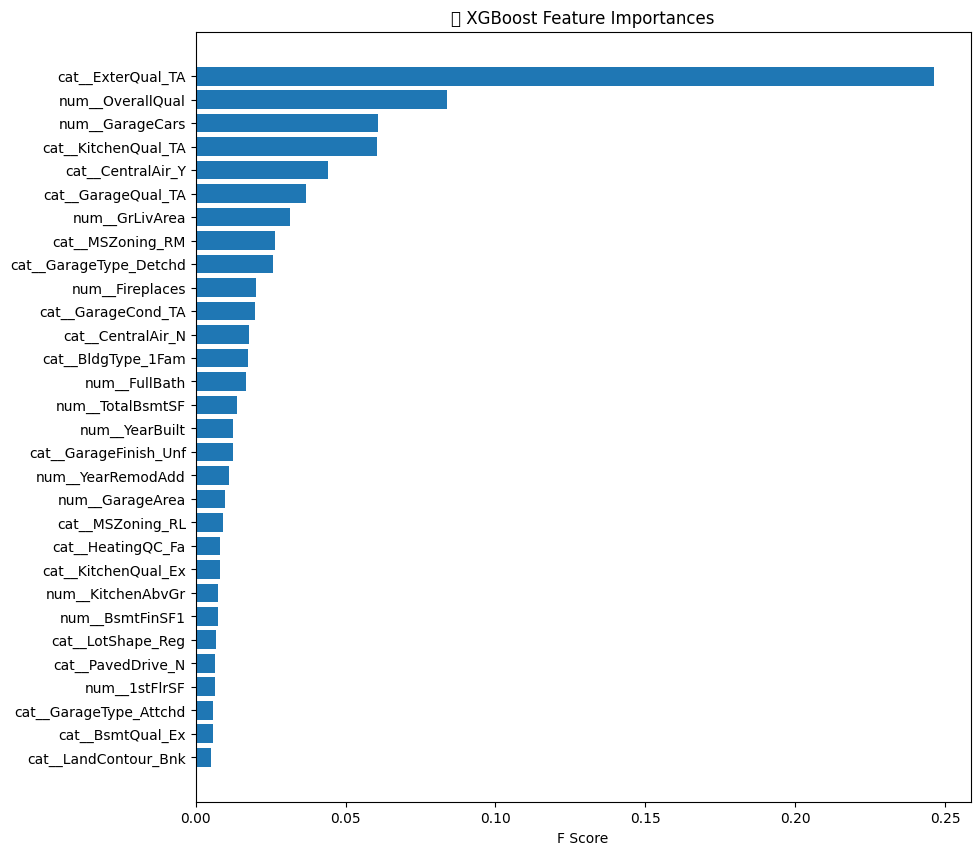

In [22]:
booster = model.named_steps['regressor']
feature_names = model.named_steps['preprocessor'].get_feature_names_out()

importances = booster.feature_importances_
indices = np.argsort(importances)[-30:]  # top 30

plt.figure(figsize=(10, 10))
plt.barh(range(len(indices)), importances[indices])
plt.yticks(range(len(indices)), [feature_names[i] for i in indices])
plt.title("🚀 XGBoost Feature Importances")
plt.xlabel("F Score")

In [28]:
# Get top N feature names
top_n = 15  # or 30, 40...
important_indices = np.argsort(importances)[-top_n:]
top_features = [feature_names[i] for i in important_indices]
top_features

['num__TotalBsmtSF',
 'num__FullBath',
 'cat__BldgType_1Fam',
 'cat__CentralAir_N',
 'cat__GarageCond_TA',
 'num__Fireplaces',
 'cat__GarageType_Detchd',
 'cat__MSZoning_RM',
 'num__GrLivArea',
 'cat__GarageQual_TA',
 'cat__CentralAir_Y',
 'cat__KitchenQual_TA',
 'num__GarageCars',
 'num__OverallQual',
 'cat__ExterQual_TA']

In [25]:
from sklearn.feature_selection import SelectFromModel

model = Pipeline([
    ('preprocessor', preprocessor),
    ('feature_selector', SelectFromModel(XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    ), threshold='median')),  # or pre-set list
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    ))
])


In [26]:
# Fit the pipeline
model.fit(X_train, y_train_log)

# Predict on validation
y_pred_log = model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_true = np.expm1(y_val_log)

# Evaluate
mae = mean_absolute_error(y_val_true, y_pred)
print(f"🚀 MAE with selected features: {mae:.2f}")


🚀 MAE with selected features: 15677.23


In [30]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
import numpy as np
import pandas as pd

# 🎯 Split the data
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# --------------------------------------------------
# 🔁 Shared Preprocessor
# --------------------------------------------------
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])

# --------------------------------------------------
# 🚀 Models
# --------------------------------------------------

# XGBoost
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    ))
])

# Ridge
ridge_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', Ridge(alpha=10.0))
])

# Random Forest
rf_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', RandomForestRegressor(
        n_estimators=200,
        max_depth=12,
        random_state=42,
        n_jobs=-1
    ))
])

# --------------------------------------------------
# 🏋️‍♂️ Train & Predict
# --------------------------------------------------
xgb_model.fit(X_train, y_train_log)
ridge_model.fit(X_train, y_train_log)
rf_model.fit(X_train, y_train_log)

y_pred_log_xgb = xgb_model.predict(X_val)
y_pred_log_ridge = ridge_model.predict(X_val)
y_pred_log_rf = rf_model.predict(X_val)

# Average predictions
y_pred_log_avg = (y_pred_log_xgb + y_pred_log_ridge + y_pred_log_rf) / 3
y_pred_avg = np.expm1(y_pred_log_avg)
y_val_true = np.expm1(y_val_log)

# --------------------------------------------------
# 📉 MAE
# --------------------------------------------------
mae = mean_absolute_error(y_val_true, y_pred_avg)
print(f"🎯 Ensemble MAE (log-transformed): {mae:.2f}")
X_test = df_test_final.copy()
# --------------------------------------------------
# 🔮 test Predictions
# --------------------------------------------------
y_test_log_xgb = xgb_model.predict(X_test)
y_test_log_ridge = ridge_model.predict(X_test)
y_test_log_rf = rf_model.predict(X_test)

y_test_preds = np.expm1((y_test_log_xgb + y_test_log_ridge + y_test_log_rf) / 3)

# --------------------------------------------------
# 📁 Submission
# --------------------------------------------------
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_preds
})
submission.to_csv('submission_ensemble.csv', index=False)


🎯 Ensemble MAE (log-transformed): 15060.90


In [16]:
df_num = df.select_dtypes(include = ['float64', 'int64'])
df_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2919 entries, 0 to 2918
Data columns (total 38 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             2919 non-null   int64  
 1   MSSubClass     2919 non-null   int64  
 2   LotFrontage    2919 non-null   float64
 3   LotArea        2919 non-null   int64  
 4   OverallQual    2919 non-null   int64  
 5   OverallCond    2919 non-null   int64  
 6   YearBuilt      2919 non-null   int64  
 7   YearRemodAdd   2919 non-null   int64  
 8   MasVnrArea     2919 non-null   float64
 9   BsmtFinSF1     2919 non-null   float64
 10  BsmtFinSF2     2919 non-null   float64
 11  BsmtUnfSF      2919 non-null   float64
 12  TotalBsmtSF    2919 non-null   float64
 13  1stFlrSF       2919 non-null   int64  
 14  2ndFlrSF       2919 non-null   int64  
 15  LowQualFinSF   2919 non-null   int64  
 16  GrLivArea      2919 non-null   int64  
 17  BsmtFullBath   2919 non-null   float64
 18  BsmtHalf

array([[<Axes: title={'center': 'Id'}>,
        <Axes: title={'center': 'MSSubClass'}>,
        <Axes: title={'center': 'LotFrontage'}>,
        <Axes: title={'center': 'LotArea'}>,
        <Axes: title={'center': 'OverallQual'}>,
        <Axes: title={'center': 'OverallCond'}>],
       [<Axes: title={'center': 'YearBuilt'}>,
        <Axes: title={'center': 'YearRemodAdd'}>,
        <Axes: title={'center': 'MasVnrArea'}>,
        <Axes: title={'center': 'BsmtFinSF1'}>,
        <Axes: title={'center': 'BsmtFinSF2'}>,
        <Axes: title={'center': 'BsmtUnfSF'}>],
       [<Axes: title={'center': 'TotalBsmtSF'}>,
        <Axes: title={'center': '1stFlrSF'}>,
        <Axes: title={'center': '2ndFlrSF'}>,
        <Axes: title={'center': 'LowQualFinSF'}>,
        <Axes: title={'center': 'GrLivArea'}>,
        <Axes: title={'center': 'BsmtFullBath'}>],
       [<Axes: title={'center': 'BsmtHalfBath'}>,
        <Axes: title={'center': 'FullBath'}>,
        <Axes: title={'center': 'HalfBath'}>,

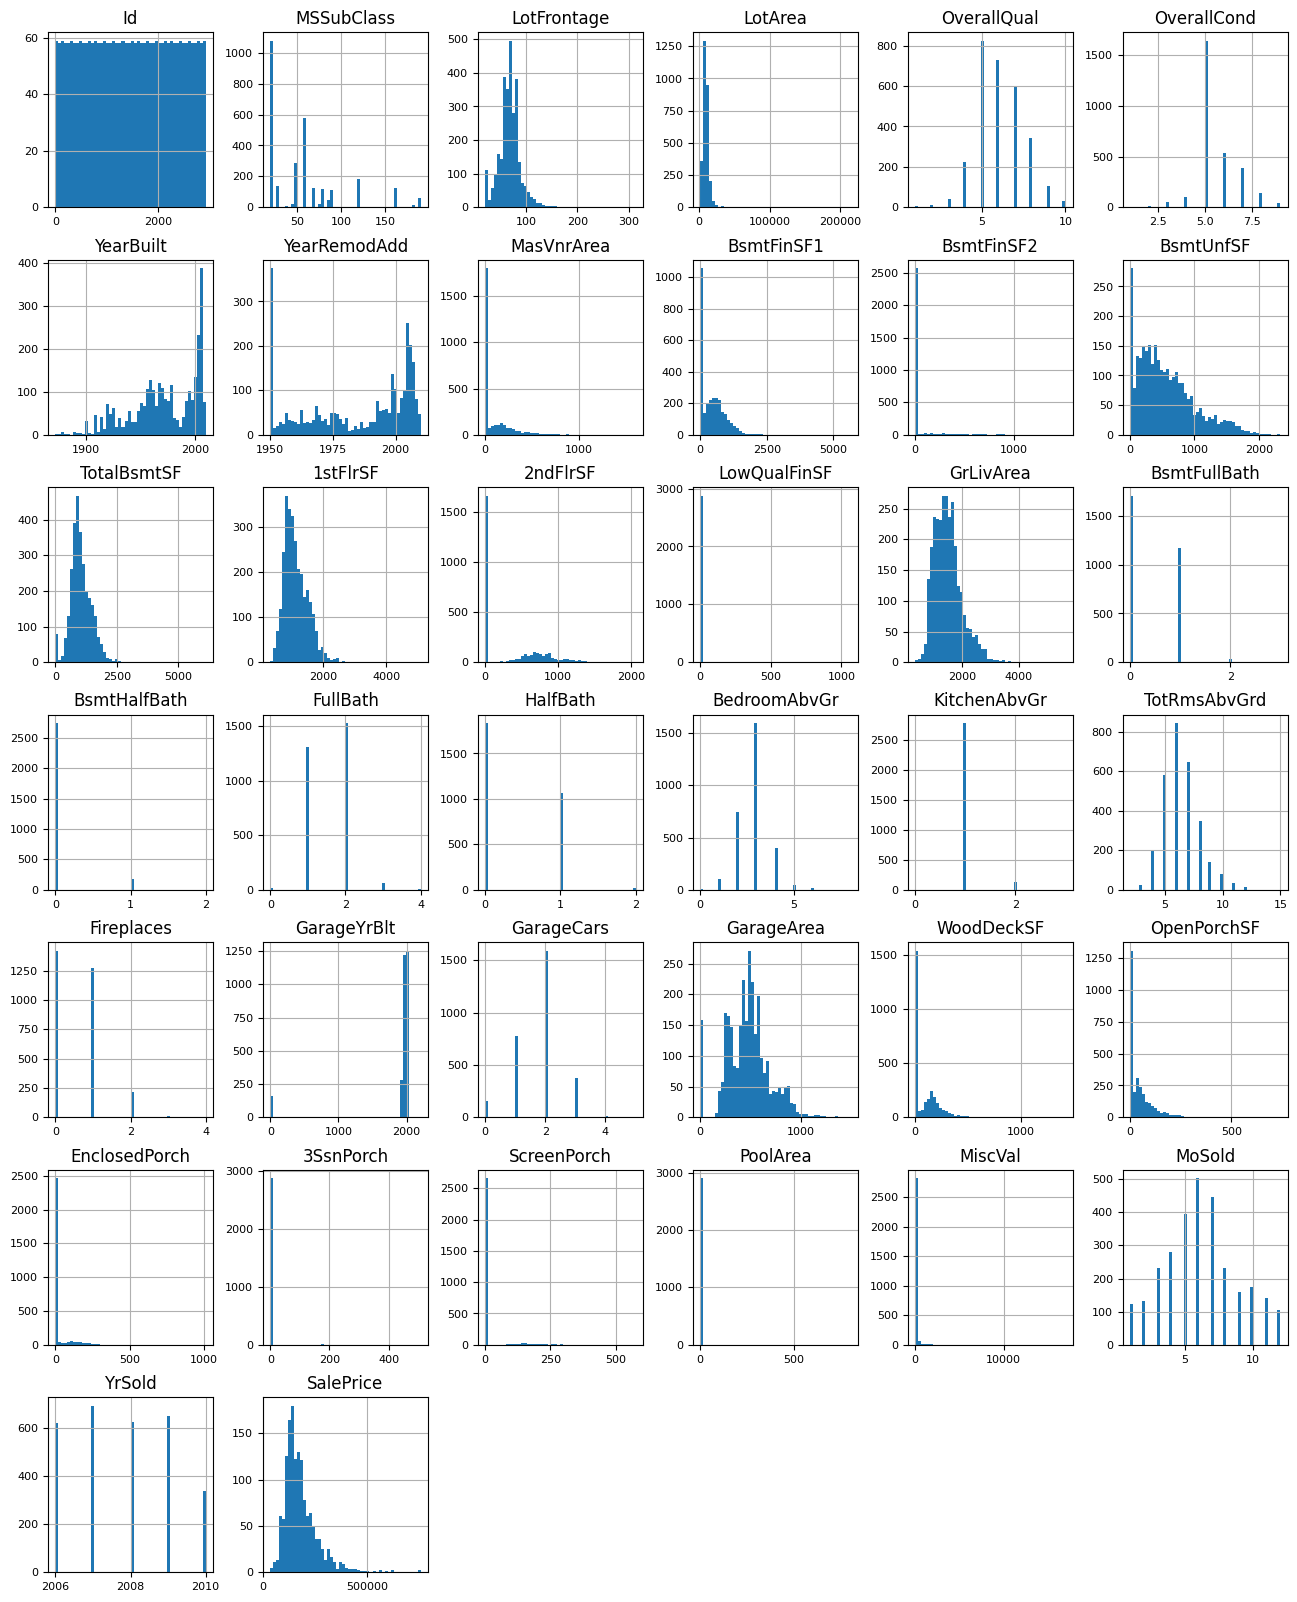

In [17]:
df_num.hist(figsize=(16, 20), bins=50, xlabelsize=8, ylabelsize=8)

In [18]:
df_Full=df.copy() # we can check this data set with no feature engineering to see compare

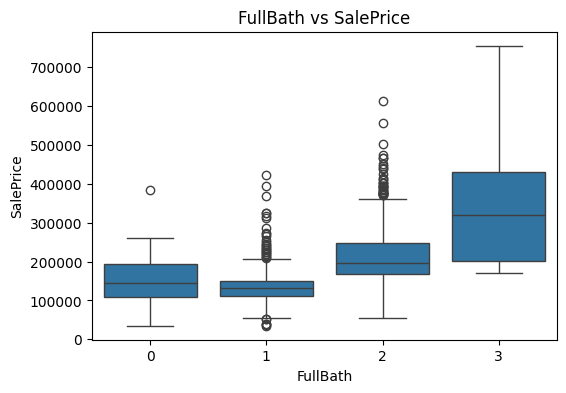

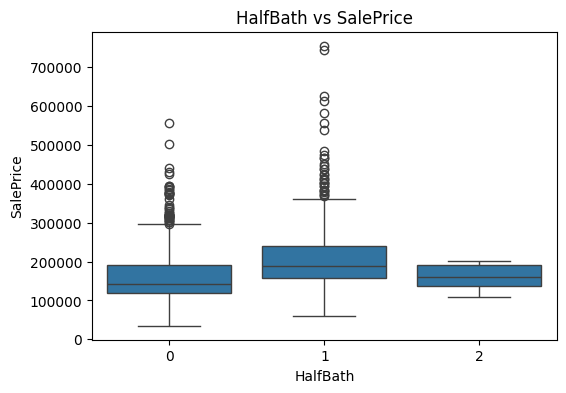

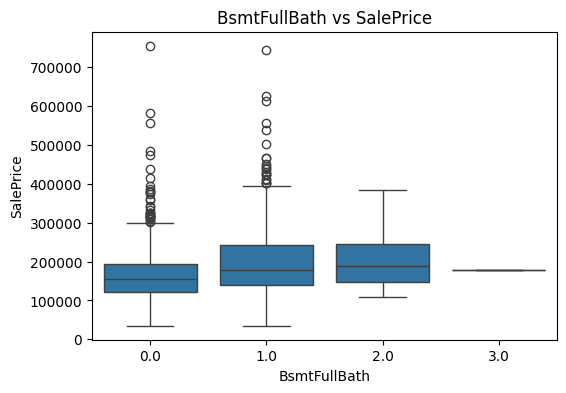

In [41]:
bath_features = ['FullBath', 'HalfBath', 'BsmtFullBath']
for feature in bath_features:
    plt.figure(figsize=(6, 4))
    sns.boxplot(x=feature, y='SalePrice', data=df[df['source'] == 'train'])
    plt.title(f"{feature} vs SalePrice")
    plt.show()

In [39]:
# df_train = df[df['source'] == 'train']

bath_features = ['FullBath', 'HalfBath', 'BsmtFullBath']

# Loop through each feature and perform ANOVA
for feature in bath_features:
    # Group SalePrice by feature values
    groups = df_train.groupby(feature)['SalePrice'].apply(list)

    # Only include groups with at least 2 samples
    valid_groups = [grp for grp in groups if len(grp) > 1]

    if len(valid_groups) < 2:
        print(f"⚠️ Not enough groups for {feature} to run ANOVA.")
        continue

    # Run ANOVA
    f_stat, p_val = stats.f_oneway(*valid_groups)

    print(f"🛁 {feature}:")
    print(f"   F-statistic = {f_stat:.2f}, p-value = {p_val:.4f}")
    if p_val < 0.05:
        print("   ✅ Statistically significant differences between groups.")
    else:
        print("   ❌ No significant difference between groups.")
    print("-" * 60)

🛁 FullBath:
   F-statistic = 246.07, p-value = 0.0000
   ✅ Statistically significant differences between groups.
------------------------------------------------------------
🛁 HalfBath:
   F-statistic = 74.47, p-value = 0.0000
   ✅ Statistically significant differences between groups.
------------------------------------------------------------
🛁 BsmtFullBath:
   F-statistic = 41.17, p-value = 0.0000
   ✅ Statistically significant differences between groups.
------------------------------------------------------------


In [32]:
df.drop(columns=['BsmtHalfBath'], inplace=True)

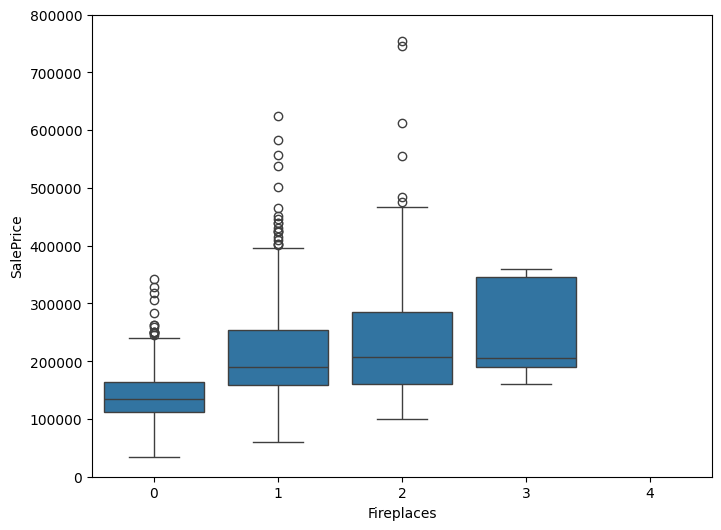

In [42]:
# box plot overallqual/saleprice
var = 'Fireplaces'
data = pd.concat([df['SalePrice'], df[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

In [43]:
# grouping
group0 = df_train[df_train['Fireplaces'] == 0]['SalePrice']
group1 = df_train[df_train['Fireplaces'] == 1]['SalePrice']
group2 = df_train[df_train['Fireplaces'] == 2]['SalePrice']
group3 = df_train[df_train['Fireplaces'] == 3]['SalePrice']

# ANOVA
f_stat, p_value = stats.f_oneway(group0, group1, group2, group3)
print(f"F-statistic: {f_stat:.2f}")
print(f"p-value: {p_value:.4f}")


F-statistic: 146.74
p-value: 0.0000


In [44]:
tukey = pairwise_tukeyhsd(endog=df_train['SalePrice'], groups=df_train['Fireplaces'], alpha=0.05)
print(tukey)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     0      1  70512.4266    0.0  60715.7662  80309.0871   True
     0      2  99257.0565    0.0  81204.8059 117309.3072   True
     0      3 110668.5174 0.0023  30225.2439 191111.7909   True
     1      2  28744.6299 0.0003  10613.2023  46876.0575   True
     1      3  40156.0908 0.5735 -40304.9878 120617.1693  False
     2      3  11411.4609 0.9842  -70465.852  93288.7737  False
---------------------------------------------------------------


In [45]:
df['HasFireplace'] = df['Fireplaces'].apply(lambda x: 1 if x > 0 else 0)

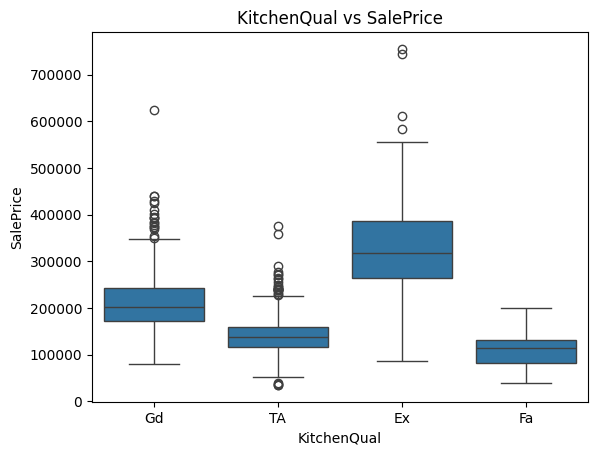

In [46]:
df[df['source'] == 'train']['KitchenQual'].value_counts()
sns.boxplot(x='KitchenQual', y='SalePrice', data=df[df['source'] == 'train'])
plt.title("KitchenQual vs SalePrice")
plt.show()

In [55]:
qual_map = {'Po': 1, 'Fa': 2, 'TA': 3, 'Gd': 4, 'Ex': 5}
df['KitchenQualScore'] = df['KitchenQual'].map(qual_map)

In [57]:
corr = df[['KitchenQualScore', 'SalePrice']].corr().iloc[0, 1]
print(f"Correlation: {corr:.2f}")
# 

Correlation: 0.66


In [58]:
df.drop('KitchenQual', axis=1, inplace=True)

In [59]:
df[df['source'] == 'train']['BedroomAbvGr'].value_counts().sort_index()


,count
BedroomAbvGr,
0,6
1,50
2,358
3,804
4,213
5,21
6,7
8,1


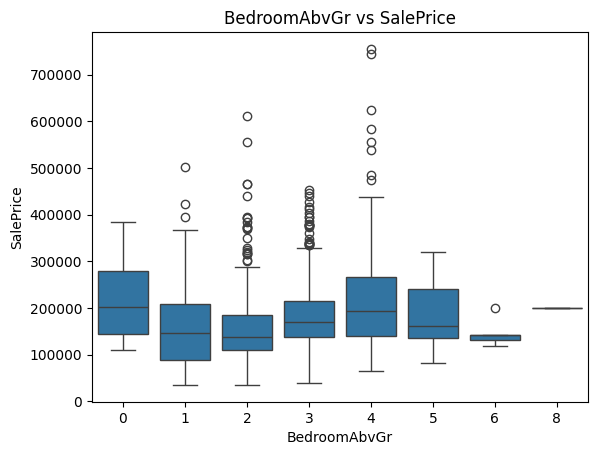

In [60]:
sns.boxplot(x='BedroomAbvGr', y='SalePrice', data=df[df['source'] == 'train'])
plt.title("BedroomAbvGr vs SalePrice")
plt.show()


In [61]:

groups = df[df['source'] == 'train'].groupby('BedroomAbvGr')['SalePrice'].apply(list)
valid_groups = [grp for grp in groups if len(grp) > 1]

f_stat, p_val = stats.f_oneway(*valid_groups)
print(f"BedroomAbvGr → F-statistic: {f_stat:.2f}, p-value: {p_val:.4f}")


BedroomAbvGr → F-statistic: 15.07, p-value: 0.0000


In [63]:
df.drop('Fireplaces', axis=1, inplace=True)

In [68]:
df_train_final = df[df['source'] == 'train'].drop(['source'], axis=1).copy()
df_test_final = df[df['source'] == 'test'].drop(['source', 'SalePrice'], axis=1).copy()
df_train_final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1460 entries, 0 to 1459
Data columns (total 74 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Id                1460 non-null   int64  
 1   MSSubClass        1460 non-null   int64  
 2   MSZoning          1460 non-null   object 
 3   LotFrontage       1460 non-null   float64
 4   LotArea           1460 non-null   int64  
 5   Street            1460 non-null   object 
 6   LotShape          1460 non-null   object 
 7   LandContour       1460 non-null   object 
 8   Utilities         1460 non-null   object 
 9   LotConfig         1460 non-null   object 
 10  LandSlope         1460 non-null   object 
 11  Neighborhood      1460 non-null   object 
 12  Condition1        1460 non-null   object 
 13  Condition2        1460 non-null   object 
 14  BldgType          1460 non-null   object 
 15  HouseStyle        1460 non-null   object 
 16  OverallQual       1460 non-null   int64  
 17  

In [70]:
# 🎯 SalePrice ve test_ids'i alalım
y = df[df['source'] == 'train']['SalePrice']
test_ids = df[df['source'] == 'test']['Id']

# 🔀 Train ve test verisini ayır
X = df[df['source'] == 'train'].drop(['SalePrice', 'source'], axis=1)
X_test = df[df['source'] == 'test'].drop(['SalePrice', 'source'], axis=1)


In [71]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

num_cols = X.select_dtypes(include=['int64', 'float64']).columns
cat_cols = X.select_dtypes(include='object').columns

preprocessor = ColumnTransformer([
    ('num', StandardScaler(), num_cols),
    ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols)
])


In [72]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
import numpy as np

# 🎯 Target log transform
y_log = np.log1p(y)

# Train/val split
X_train, X_val, y_train_log, y_val_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

# 🚀 XGBoost pipeline
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('regressor', XGBRegressor(
        n_estimators=500,
        learning_rate=0.05,
        max_depth=3,
        subsample=0.8,
        colsample_bytree=0.8,
        min_child_weight=1,
        random_state=42,
        verbosity=0
    ))
])

# 🏋️‍♂️ Train
xgb_model.fit(X_train, y_train_log)

# 🔍 Predict & MAE
y_pred_log = xgb_model.predict(X_val)
y_pred = np.expm1(y_pred_log)
y_val_true = np.expm1(y_val_log)

mae = mean_absolute_error(y_val_true, y_pred)
print(f"🚀 XGBoost MAE (log-transformed): {mae:.2f}")


🚀 XGBoost MAE (log-transformed): 15104.01


<ipython-input-73-ded2d815e833>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')


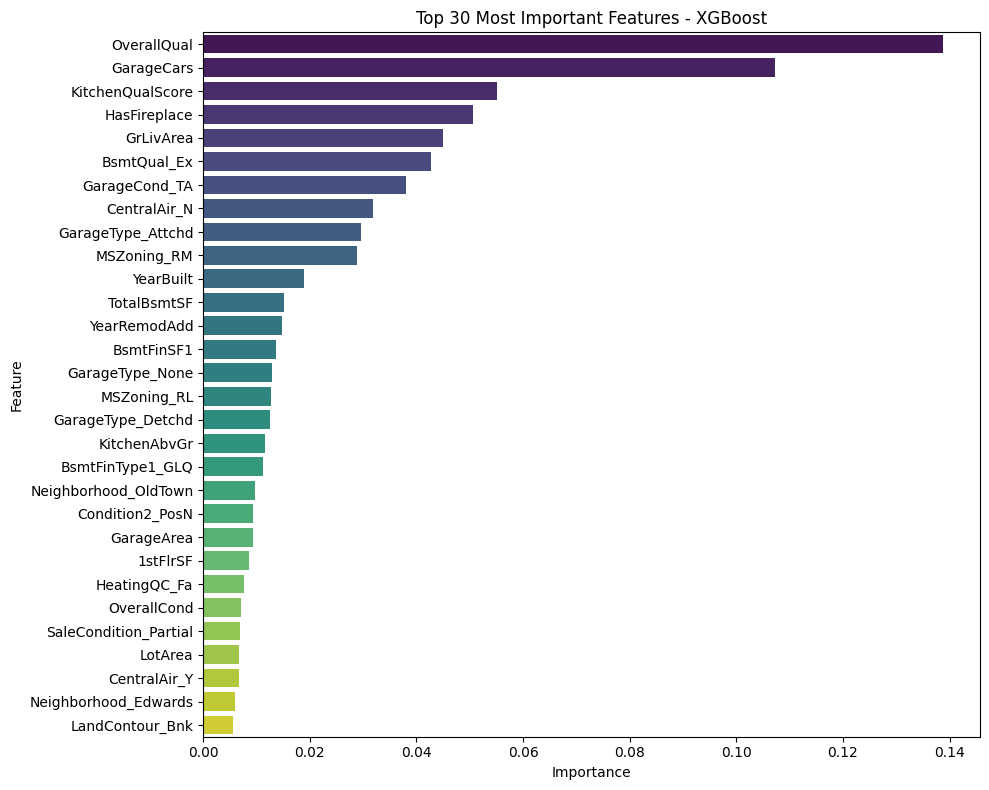

In [73]:
import matplotlib.pyplot as plt
import seaborn as sns

# model içindeki XGBoost kısmını çıkar
xgb = xgb_model.named_steps['regressor']

# One-hot encoding sonrası feature isimlerini al
ohe = xgb_model.named_steps['preprocessor'].transformers_[1][1]
cat_features = ohe.get_feature_names_out(input_features=cat_cols)
all_features = list(num_cols) + list(cat_features)

# importance değerlerini al
importances = xgb.feature_importances_
feature_importance_df = pd.DataFrame({
    'Feature': all_features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False).head(30)

# Görselleştirme
plt.figure(figsize=(10, 8))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature', palette='viridis')
plt.title('Top 30 Most Important Features - XGBoost')
plt.tight_layout()
plt.show()


In [74]:
# ✅ test set prediction
y_test_log = xgb_model.predict(X_test)
y_test_pred = np.expm1(y_test_log)  # inverse log

# ✅ Create submission file
submission = pd.DataFrame({
    'Id': test_ids,
    'SalePrice': y_test_pred
})

# 💾 Save to CSV
submission.to_csv('submission.csv', index=False)
print("✅ Submission file created: submission.csv")


✅ Submission file created: submission.csv
